<a href="https://colab.research.google.com/github/cristi2019255/DigitRecognition/blob/main/Pattern_recognition_assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.linear_model import 	LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
import cv2
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import math

##Loading data

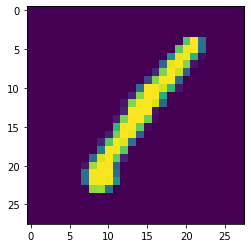

In [3]:
mnist_data = pd.read_csv('/content/drive/MyDrive/Pattern_recognition_assignment_1/mnist.csv').values
labels = mnist_data[:, 0]
digits = mnist_data[:, 1:]
img_size = 28
plt.imshow(digits[0].reshape(img_size, img_size))
plt.show()

## Data analisys and preprocessing

{0: 0.09838095238095237, 1: 0.11152380952380953, 2: 0.09945238095238096, 3: 0.1035952380952381, 4: 0.09695238095238096, 5: 0.09035714285714286, 6: 0.0985, 7: 0.10478571428571429, 8: 0.09673809523809523, 9: 0.09971428571428571}
0.11152380952380953


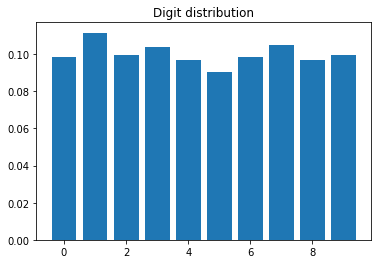

In [4]:
# Data consists of 42k rows representing a digit from 0-9, and 784 columns
# representing a pixel and the corresponding grey value (0-255). 
unique_digits, counts = np.unique(labels, return_counts=True)
N = len(labels) # 42k in our case representing the size of the sample of handwritten digits.
rel_freq = list(map(lambda n : n/N, counts))
distribution = dict(zip(unique_digits, rel_freq))
print(distribution)
print(max(distribution.values()))
plt.title("Digit distribution")
bar = plt.bar(unique_digits,[counts[i] / 42000 for i in range(10)])

1) If we predict the majority class (namely class 1) then 11.152 % of data will be classified correctly


In [5]:
# overlay all matrices
def overlay_matrices(digits, percent_trashhold = 0.01):
  N = len(digits)  
  final_img = np.reshape(digits[0], (28, 28)) 
  for digit in digits[1:]:    
    img = np.reshape(digit, (28, 28))
    final_img = np.add(final_img, img)      
  final_img = final_img / 255    
  final_img[final_img < (percent_trashhold * N)] = 0.0  
  
  return final_img


def filter_empty(img):  
  trash_rows = []
  sums_rows = img.sum(axis=1)
  for x in range(len(sums_rows)):
    if sums_rows[x] == 0:
      trash_rows.append(x)

  trash_columns = []  
  sums_columns = img.sum(axis=0)
  for x in range(len(sums_columns)):
    if sums_columns[x] == 0:
      trash_columns.append(x)
  
  return trash_rows, trash_columns

def reshape_dataset(digits, img_size = 28):
  return np.array([np.reshape(sample, (img_size, img_size))  for sample in digits])

# remove (almost) empty row/colums from the images
def preprocess_dataset(digits):
  dataset = reshape_dataset(digits)  
  rows_to_del, cols_to_del = filter_empty(overlay_matrices(dataset))
  print(rows_to_del, cols_to_del)
  
  '''
    intersecting rows indexes and column indexes that can be deleted
    to obtain a square image when deleting rows and columns
  '''
  filtered_delete = [value for value in rows_to_del if value in cols_to_del]
  new_img_size = img_size - len(filtered_delete)  

  proccessed_dataset = []
  for img in dataset:    
    img = np.delete(img, filtered_delete, 0)
    img = np.delete(img, filtered_delete, 1)
    proccessed_dataset.append(img)

  return proccessed_dataset, new_img_size

# plt.imshow(overlay_matrices(digits, 0.01))

In [6]:
preprocessed, img_size = preprocess_dataset(digits)
print(len(preprocessed), img_size)

[0, 1, 27] [0, 1, 2, 3, 25, 26, 27]
42000 25


## Feature extraction

In [36]:
def plot_conf_matrix(conf_matrix, title):  
  fig, ax = plt.subplots(figsize=(7.5, 7.5))
  ax.matshow(conf_matrix, cmap=plt.cm.Blues)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='large')
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix'+title, fontsize=15)
  plt.show()

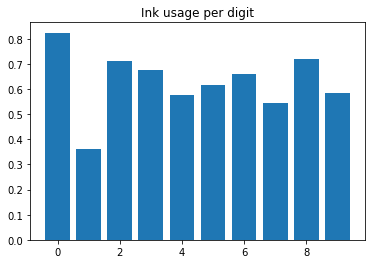

In [16]:
# create ink feature
ink = np.array([sum(row) for row in digits])
#compute mean for each digit class
ink_mean = [np.mean(ink[labels == i]) for i in range(10)]
ink_mean = [ink_mean[i] / 42000 for i in range(10)]

#print(ink_mean)
#compute standard deviation for each digit class
ink_std = [np.std(ink[labels == i]) for i in range(10)]
#The reshape is neccesary to call LogisticRegression() with a single feature
ink = scale(ink).reshape(-1, 1)

plt.title("Ink usage per digit")
bar = plt.bar(unique_digits,ink_mean)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


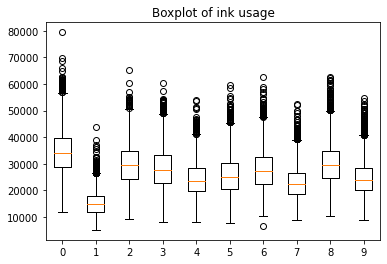

In [17]:
ink_digits = [[], [], [], [], [], [], [], [], [], []]
for i in range(N):
  # print(labels[i])
  ink_digits[labels[i]].append(sum(digits[i]))
# print(ink_digits)
# fig, ax = plt.subplots()
plt.boxplot(ink_digits, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.title("Boxplot of ink usage")
plt.show()

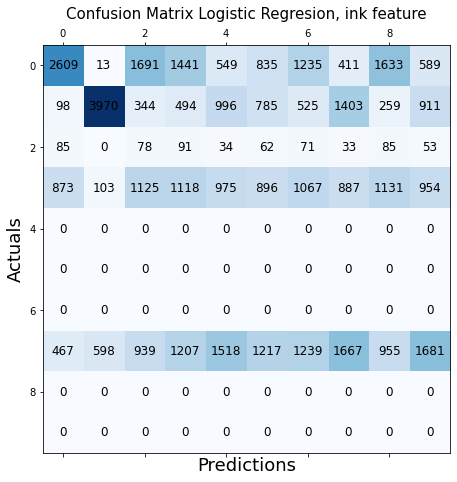

[[2609   13 1691 1441  549  835 1235  411 1633  589]
 [  98 3970  344  494  996  785  525 1403  259  911]
 [  85    0   78   91   34   62   71   33   85   53]
 [ 873  103 1125 1118  975  896 1067  887 1131  954]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [ 467  598  939 1207 1518 1217 1239 1667  955 1681]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]


0.22480952380952382

In [38]:
logistic_regression = LogisticRegression(solver='liblinear', penalty='l1').fit(ink,labels)
y_pred = logistic_regression.predict(ink)
conf_matrix = confusion_matrix(y_pred, labels)
plot_conf_matrix(conf_matrix, title = ' Logistic Regresion, ink feature')
print(conf_matrix)
accuracy_score(y_pred, labels)

Ink feature gives only 22.68 % accuracy

In [39]:
'''
spliting each image in 16 non-overlapping blocks
'''
def split_blocks(img, kernel_size = (5,5)):
  blocks = [img[x:x+kernel_size[0],y:y+kernel_size[1]] for x in range(0,img.shape[0],kernel_size[0]) for y in range(0,img.shape[1],kernel_size[1])]  
  return blocks

def ink_blocks(blocks):  
  return np.array([sum(sum(block)) for block in blocks])

In [40]:
ink_blocks_features = np.array([ink_blocks(split_blocks(x)) for x in preprocessed])

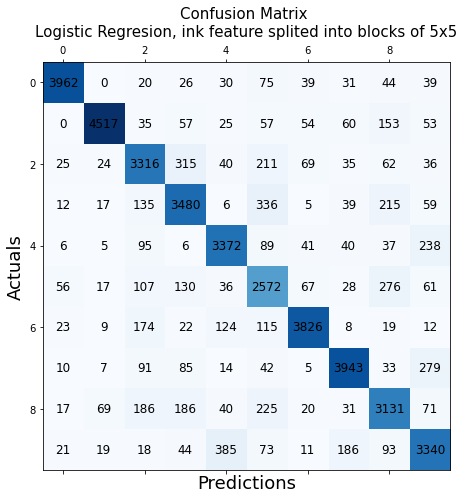

[[3962    0   20   26   30   75   39   31   44   39]
 [   0 4517   35   57   25   57   54   60  153   53]
 [  25   24 3316  315   40  211   69   35   62   36]
 [  12   17  135 3480    6  336    5   39  215   59]
 [   6    5   95    6 3372   89   41   40   37  238]
 [  56   17  107  130   36 2572   67   28  276   61]
 [  23    9  174   22  124  115 3826    8   19   12]
 [  10    7   91   85   14   42    5 3943   33  279]
 [  17   69  186  186   40  225   20   31 3131   71]
 [  21   19   18   44  385   73   11  186   93 3340]]


0.8442619047619048

In [42]:
logistic_regression = LogisticRegression(solver='liblinear', penalty='l1').fit(ink_blocks_features,labels)
y_pred = logistic_regression.predict(ink_blocks_features)
conf_matrix = confusion_matrix(y_pred, labels)
plot_conf_matrix(conf_matrix, title = ' \nLogistic Regresion, ink feature splited into blocks of 5x5')
print(conf_matrix)
accuracy_score(y_pred, labels)

In [43]:
# create The Contour feature
def starting_point(x):
    '''
      x - a matrix (ndarray)
      output - coordinates of the starting point
      Starting point is the first value(pixel) in the matrix x that is not 0
      when iterating the matrix in spiral form
    '''
    k = 0
    l = 0
    n, m = len(x), len(x[0])
  
    ''' k - starting row index 
        m - ending row index 
        l - starting column index 
        n - ending column index 
        i - iterator 
    '''     
  
    while (k < m and l < n) : 
          
        # Iterate first row from 
        # the remaining rows  
        for i in range(l, n) : 
            if (x[k][i]>0):
              return k,i              
        k += 1
  
        # Iterate last column from 
        # the remaining columns  
        for i in range(k, m) : 
            if (x[i][n-1]>0):
              return i, n - 1                            
        n -= 1
  
        # Iterate the last row from 
        # the remaining rows  
        if ( k < m) :               
            for i in range(n - 1, (l - 1), -1) : 
                if (x[m-1][i]>0):
                  return m-1,i                
              
            m -= 1
          
        # Iterate the first column from 
        # the remaining columns  
        if (l < n) : 
            for i in range(m - 1, k - 1, -1) : 
              if (x[i][l]>0):
                  return i,l                              
            l += 1

    # if no starting point is found then returning -1, -1            
    return -1, -1    

def calculate_histogram(x, s_x, s_y):  
  """
    Calculating histogram of pixels occurances in 8 directions
    from the starting point.
    x - matrix (img of type ndarray)
    s_x, s_y - coordinates of the starting point
  """
  
  [d_0, d_1, d_2, d_3, d_4, d_5, d_6, d_7] = [0] * 8
  
  if (s_x == -1) and (s_y == -1):
    return [d_0, d_1, d_2, d_3, d_4, d_5, d_6, d_7]

  n, m  = len(x), len(x[0])

  '''direction 0 right'''  
  if (s_y < m ):
    d_0 = sum(x[s_x][s_y+1:])   

  '''direction 1 up-right'''  
  if (s_y < m) and (s_x > 0):
    j = s_y    
    for i in range(s_x, 0,-1):      
      d_1 += x[i][j]       
      if (j == m-1):
        break 
      j += 1
    d_1 -= x[s_x][s_y]
  
  '''direction 2 up'''  
  if (s_x > 0 ):
    d_2 = sum([x[i][s_y] for i in range(s_x)])    
   
  '''direction 3 up-left'''  
  if (s_y > 0 ) and (s_x > 0):
    j = s_y
    for i in range(s_x, 0,-1):
      d_3 += x[i][j]       
      if (j == 0):
        break 
      j -= 1
    d_3 -= x[s_x][s_y]

  '''direction 4 left'''  
  if (s_y > 0 ):
    d_4 = sum(x[s_x][:s_y])    

  '''direction 5 down-left'''  
  if (s_y > 0 ) and (s_x < n):
    j = s_y 
    for i in range(s_x, n):
      d_5 += x[i][j]       
      if (j == 0):
        break 
      j -= 1
    d_5 -= x[s_x][s_y]  

  '''direction 6 down'''  
  if (s_x < n ):
    d_6 = sum([x[i][s_y] for i in range(s_x + 1,n)])    
     
  '''direction 7 down-right'''  
  if (s_y < m ) and (s_x < n):
    j = s_y 
    for i in range(s_x, n):
      d_7 += x[i][j]       
      if (j == m - 1):
        break 
      j += 1
    d_7 -= x[s_x][s_y]

  return [d_0, d_1, d_2, d_3, d_4, d_5, d_6, d_7]

def extract_contur_features(dataset, kernel_size = (5,5)):
  """
    extracting contur features from dataset
    output: features - a list of feature_vectors       
  """
  features = []
  for img in dataset:    
    feature_vector = []    
    # converting image from grayscale to binary
    (_, img) = cv2.threshold(img.astype('uint8'), 127, 255, cv2.THRESH_BINARY)    

    # splitting image into blocks of size kernel size
    blocks = split_blocks(img, kernel_size= kernel_size)

    # for each block search for starting point, calculate histogram of occurances
    # append histogram to feature vector
    for block in blocks:    
        s_x, s_y  = starting_point(block)
        feature_vector += calculate_histogram(block, s_x, s_y)        
    
    features.append(feature_vector)

  return features

In [44]:
contur_features = extract_contur_features(preprocessed)

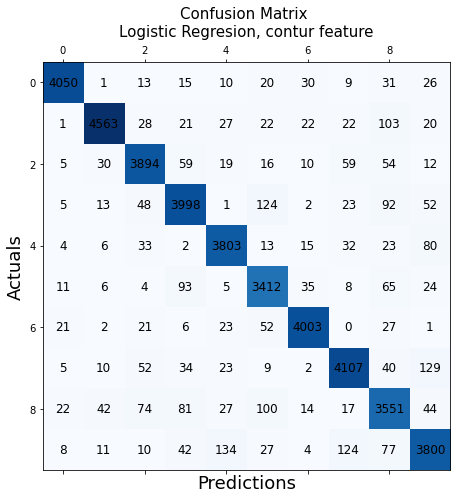

[[4050    1   13   15   10   20   30    9   31   26]
 [   1 4563   28   21   27   22   22   22  103   20]
 [   5   30 3894   59   19   16   10   59   54   12]
 [   5   13   48 3998    1  124    2   23   92   52]
 [   4    6   33    2 3803   13   15   32   23   80]
 [  11    6    4   93    5 3412   35    8   65   24]
 [  21    2   21    6   23   52 4003    0   27    1]
 [   5   10   52   34   23    9    2 4107   40  129]
 [  22   42   74   81   27  100   14   17 3551   44]
 [   8   11   10   42  134   27    4  124   77 3800]]
0.9328809523809524


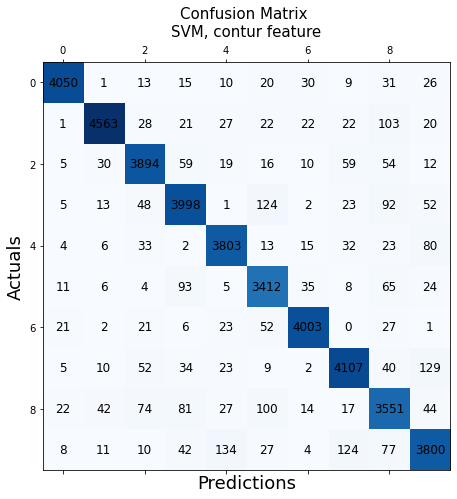

[[4050    1   13   15   10   20   30    9   31   26]
 [   1 4563   28   21   27   22   22   22  103   20]
 [   5   30 3894   59   19   16   10   59   54   12]
 [   5   13   48 3998    1  124    2   23   92   52]
 [   4    6   33    2 3803   13   15   32   23   80]
 [  11    6    4   93    5 3412   35    8   65   24]
 [  21    2   21    6   23   52 4003    0   27    1]
 [   5   10   52   34   23    9    2 4107   40  129]
 [  22   42   74   81   27  100   14   17 3551   44]
 [   8   11   10   42  134   27    4  124   77 3800]]
0.977547619047619


In [45]:
logistic_regression = LogisticRegression(solver='liblinear', penalty='l1').fit(contur_features,labels)
y_pred = logistic_regression.predict(contur_features)
conf_matrix = confusion_matrix(y_pred, labels)
plot_conf_matrix(conf_matrix, title = ' \nLogistic Regresion, contur feature')
print(conf_matrix)
print(accuracy_score(y_pred, labels))

# training an svm, just for interest
svm_clf = svm.SVC().fit(contur_features,labels)
y_pred = svm_clf.predict(contur_features)
conf_matrix = confusion_matrix(y_pred, labels)
plot_conf_matrix(conf_matrix, title = ' \nSVM, contur feature')
print(conf_matrix)
print(accuracy_score(y_pred, labels))

Accuracy improved from 22 % to 72 % that shows how dimensionality reduction matters 

## Cross validation

In [46]:
#each digit in the initial dataset (digits) is resized from (28,28) to (14,14)
resized = np.array([cv2.resize(np.reshape(sample, (28, 28)).astype('uint8'), dsize=(14, 14)).flatten() for sample in digits])
print(len(resized))

42000


In [ ]:
def sinhKernel (X,Y):    
  return np.inner(X,X)

In [47]:
# selecting at random 5000 samples from data 
N = len(resized)
random_indices = np.random.choice(N, size=5000, replace=False)
test_indices = list(set(list(range(N))) - set(random_indices))
# spliting into train and test data
train_X, train_y = resized[random_indices, :], labels[random_indices]
test_X, test_y = resized[test_indices,:], labels[test_indices]

# Making cross validation on 5 folders on train data
cv = 5
'''
Grid search cross validation for Logistic Regression parameter tunning
'''
C = [10**x for x in np.arange(5.0,-5.0, -0.1)]

grid_search_lr = GridSearchCV(
                    cv = cv,
                    estimator = LogisticRegression(solver='liblinear', 
                                                   penalty='l1'),
                    param_grid = {'C':C} # C = 1/lambda
                   )
'''
Grid search cross validation for Support vector Machines parameter tunning
'''
grid_search_svm = GridSearchCV(
                    cv = cv,
                    estimator = svm.SVC(random_state=0),
                    param_grid = {'kernel':['linear', 'rbf', 'poly'],
                                  'C':C}
                   )
'''
Grid search cross validation for Neural Networks parameter tunning
'''
grid_search_NN = GridSearchCV(
                    cv = cv,
                    estimator = MLPClassifier(random_state=0),
                    param_grid = {
                                  'hidden_layer_sizes': [(400,),(200,),(100,),(50,),(20,)],
                                  'activation': ['tanh', 'relu', 'logistic','identity'],
                                  'solver': ['sgd', 'adam'],
                                 }
                   )

In [ ]:
grid_results_lr = grid_search_lr.fit(train_X,train_y)

0.019952623149689888


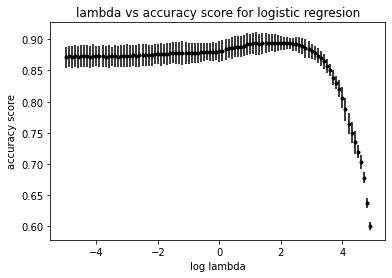

In [ ]:
'''
    ploting results
'''
fig, ax = plt.subplots()
ax.set_title('lambda vs accuracy score for logistic regresion')
ax.set_xlabel('log lambda')
ax.set_ylabel('accuracy score')
ax.errorbar([x for x in np.arange(-5,5,0.1)], grid_results_lr.cv_results_['mean_test_score'], yerr = grid_results_lr.cv_results_['std_test_score'], fmt='.k', linestyle='None')

best_lambda_lr = grid_results_lr.best_params_['C']
print(best_lambda_lr)

best lambda 0.019952623149689888

In [48]:
grid_results_svm = grid_search_svm.fit(train_X,train_y)

Best params for svm are:  7.943282347243081 rbf
7.943282347243081
rbf


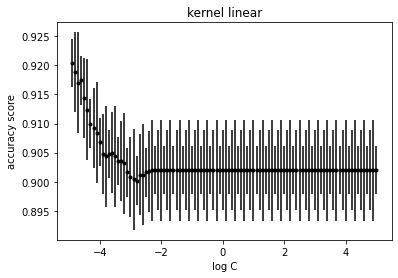

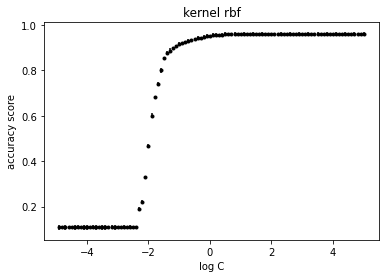

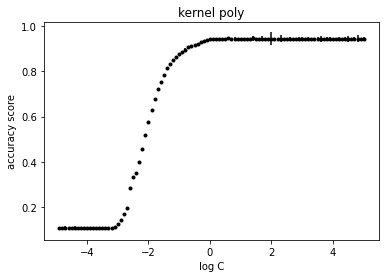

In [50]:

fig, ax1 = plt.subplots()
ax1.set_title('kernel linear')  
ax1.set_xlabel('log C')
ax1.set_ylabel('accuracy score')
ax1.errorbar(np.arange(5,-5,-0.1), grid_results_svm.cv_results_['mean_test_score'][::3], yerr = grid_results_svm.cv_results_['std_test_score'][:100] ,label= 'with kernel linear', fmt='.k', linestyle='None')
  
fig, ax2 = plt.subplots()
ax2.set_title('kernel rbf')  
ax2.set_xlabel('log C')
ax2.set_ylabel('accuracy score')
ax2.errorbar(np.arange(5,-5,-0.1), grid_results_svm.cv_results_['mean_test_score'][1::3], yerr = grid_results_svm.cv_results_['std_test_score'][100:200], label= 'with kernel rbf', fmt='.k', linestyle='None')

fig, ax3 = plt.subplots()
ax3.set_title('kernel poly')  
ax3.set_xlabel('log C')
ax3.set_ylabel('accuracy score')
ax3.errorbar(np.arange(5,-5,-0.1), grid_results_svm.cv_results_['mean_test_score'][2::3], yerr = grid_results_svm.cv_results_['std_test_score'][200:300] ,label= 'with kernel linear', fmt='.k', linestyle='None')

best_C_svm = grid_results_svm.best_params_['C']
best_kernel_svm = grid_results_svm.best_params_['kernel']


print('Best params for svm are: ', best_C_svm, best_kernel_svm)
print(best_C_svm)
print(best_kernel_svm)

In [ ]:
grid_results_NN = grid_search_NN.fit(train_X,train_y)

Best params for FF NN are:  (400,) logistic adam


<ErrorbarContainer object of 3 artists>

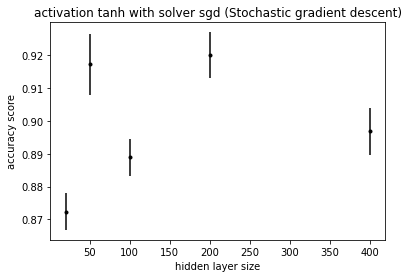

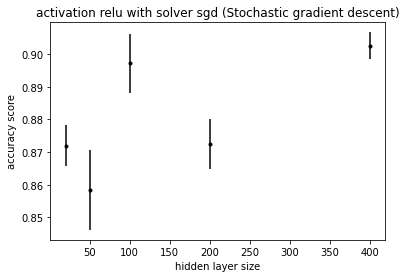

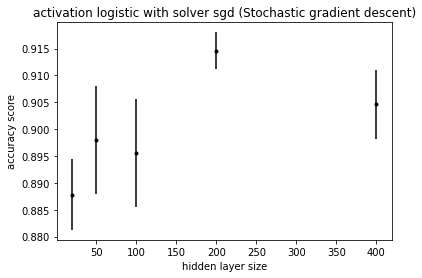

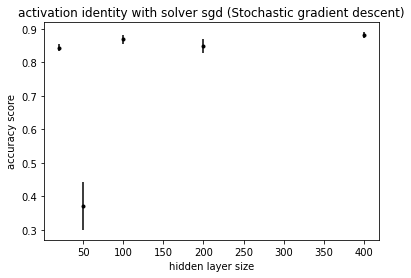

In [52]:
best_hidden_layer_sizes_NN = grid_results_NN.best_params_['hidden_layer_sizes']
best_activation_NN = grid_results_NN.best_params_['activation']
best_solver_NN = grid_results_NN.best_params_['solver']

print('Best params for FF NN are: ', best_hidden_layer_sizes_NN, best_activation_NN, best_solver_NN)


fig, ax1 = plt.subplots()
ax1.set_title('activation tanh with solver sgd (Stochastic gradient descent)')  
ax1.set_xlabel('hidden layer size')
ax1.set_ylabel('accuracy score')
ax1.errorbar([400,200,100,50,20], grid_results_NN.cv_results_['mean_test_score'][:5], yerr = grid_results_NN.cv_results_['std_test_score'][:5], fmt='.k', linestyle='None')
  
fig, ax2 = plt.subplots()
ax2.set_title('activation relu with solver sgd (Stochastic gradient descent)')  
ax2.set_xlabel('hidden layer size')
ax2.set_ylabel('accuracy score')
ax2.errorbar([400,200,100,50,20], grid_results_NN.cv_results_['mean_test_score'][5:10], yerr = grid_results_NN.cv_results_['std_test_score'][5:10] , fmt='.k', linestyle='None')

fig, ax3 = plt.subplots()
ax3.set_title('activation logistic with solver sgd (Stochastic gradient descent)')  
ax3.set_xlabel('hidden layer size')
ax3.set_ylabel('accuracy score')
ax3.errorbar([400,200,100,50,20], grid_results_NN.cv_results_['mean_test_score'][10:15], yerr = grid_results_NN.cv_results_['std_test_score'][10:15] , fmt='.k', linestyle='None')

fig, ax4 = plt.subplots()
ax4.set_title('activation identity with solver sgd (Stochastic gradient descent)')  
ax4.set_xlabel('hidden layer size')
ax4.set_ylabel('accuracy score')
ax4.errorbar([400,200,100,50,20], grid_results_NN.cv_results_['mean_test_score'][15:20], yerr = grid_results_NN.cv_results_['std_test_score'][15:20] , fmt='.k', linestyle='None')
                               

## Experiments and results

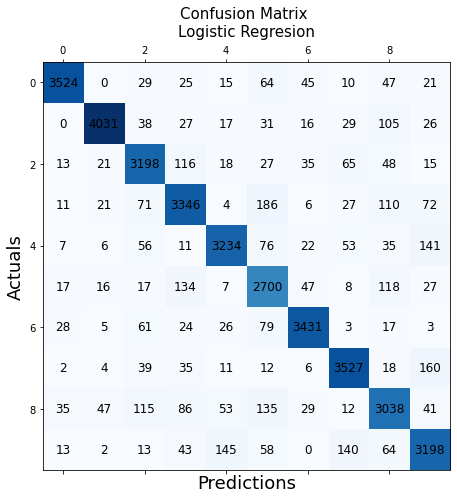

Acc lr:  0.8980270270270271


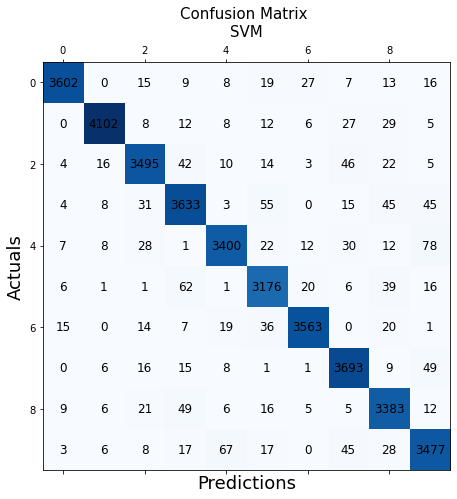

Acc svm:  0.9601081081081081


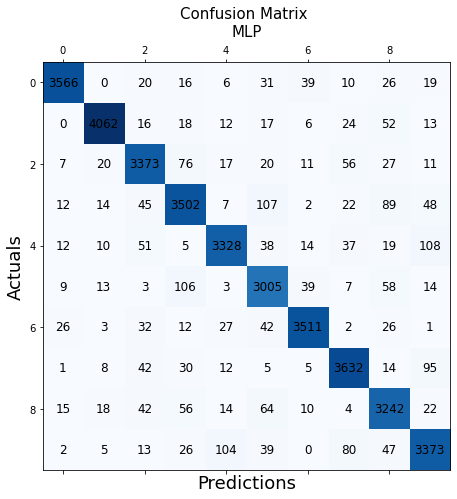

Acc NN:  0.934972972972973


In [56]:
# Experiments with the found hyper parameters
lr = LogisticRegression(solver='liblinear', 
                        penalty='l1',
                        C = best_lambda_lr
                        ).fit(train_X, train_y)

svm_clf = svm.SVC(
              kernel= best_kernel_svm,
              C= best_C_svm
              ).fit(train_X,train_y)

nn = MLPClassifier(
                    hidden_layer_sizes = best_hidden_layer_sizes_NN,
                    activation = best_activation_NN,
                    solver = best_solver_NN,
                    #alpha = best_alpha_NN,
                    #learning_rate = best_learning_rate_NN 
                  ).fit(train_X,train_y)

y_pred_lr = lr.predict(test_X)
y_pred_svm = svm_clf.predict(test_X)
y_pred_mlp = nn.predict(test_X)

conf_matrix = confusion_matrix(y_pred_lr, test_y)
plot_conf_matrix(conf_matrix, title = ' \nLogistic Regresion')
print(f'Acc lr: ' ,accuracy_score(y_pred_lr, test_y))

conf_matrix = confusion_matrix(y_pred_svm, test_y)
plot_conf_matrix(conf_matrix, title = ' \nSVM')
print(f'Acc svm: ' ,accuracy_score(y_pred_svm, test_y))

conf_matrix = confusion_matrix(y_pred_mlp, test_y)
plot_conf_matrix(conf_matrix, title = ' \nMLP')
print(f'Acc NN: ' ,accuracy_score(y_pred_mlp, test_y))

In [ ]:
# Acc lr:  0.899
# Acc svm:  0.9637027027027028
# Acc NN:  0.934972972972973